# The Blood-Brain Barrier - A Controlled Experiment

The human brain is protected from bacteria and toxins, which course through the bloodstream, by a single layer of cells called the *blood-brain barrier*.  This barrier normally alllows only a few substances, including some medications, to reach the brain.  Because chemicals used to treat brain cells have such large molecular size, they cannot pass through the barrier to attack tumor cells.  At the Oregon Health Sciences University. Dr. E. A. Newwelt developed a method of disrupting the barrier by infusing a solution of concentrated sugars.

As a test of the disruption mechanism, researchers conducted a study on rats, which possess a similar barrier.  (Data from P. Barnett et al., "Differential Permeability and Quantitative MR Imaging of a Human Lung Carcinoma Brain Xenograft in the Nude Rat," *American Journal of Pathology* 146(2) (1995): 436-49.) . The rats were innoculated with human lung cancer cells to induce brain tumors.  After 9 to 11 days they were infused with either the barrier disruption (BD) solution or, as a control, a normal saline (NS) solution.  Fifteen minutes later, the rats received a standard dose of the therapeutic antibody $L6\mathrm{-}F(ab\prime)_2$.  After a set time they were sacrificed, and the amounts of antibody in the brain tumor and in normal tissue were measured.

Since the amount of the antibody in normal tissue indicates how much of it the rat actually received, a key measure of the effectiveness of transmission across the blood-brain barrier is the ratio of the antibody concentration in the brain tumor to the antibody concentration in normal tissue outside the brain.  The brain tumor concentration divided by the liver concentration is a measure of the amount of the antibody that reached the brain relative to the amount of it that reaeched other parts of the body.  This is the response variable.  The explanatory variables comprise two two categories:  *design variables* are those that describe manipulation by the researcher; *covariates* are those measuring characteristics of the subjects that were not controllable by the researcher.

Was the antibody concentration in the brain tumor increased by the use of the blood-brain barrier disruption infusion?  If so, by how much?  Do the answers to these two questions depend on the length of time after the infusion (from 1/2 to 72 hours)?  What is the effect of treatment on antibody concentration after weight loss, total tumor weight, and the other covariates are accounted for?

In [1]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import statsmodels.formula.api as smf

sns.set()
pd.options.display.float_format = "{:.3f}".format
pd.options.display.max_columns = 12

We begin by reading the data and summarizing the variables.

In [2]:
path = pathlib.Path.home() / 'data' / 'sleuth3' / 'case1102.csv'
df = pd.read_csv(path)
df.head()

,Brain,Liver,Time,Treatment,Days,Sex,Weight,Loss,Tumor
0,41081,1456164,0.500,BD,10,Female,239,5.900,221
1,44286,1602171,0.500,BD,10,Female,225,4.000,246
2,102926,1601936,0.500,BD,10,Female,224,-4.900,61
3,25927,1776411,0.500,BD,10,Female,184,9.800,168
4,42643,1351184,0.500,BD,10,Female,250,6.000,164


In [13]:
df['Concentration'] = df['Brain'] / df['Liver']
df.loc[df.Treatment == 'BD', 'LTreatment'] = 'Barrier Disruption'
df.loc[df.Treatment == 'NS', 'LTreatment'] = 'Saline Control'

In [14]:
summary = df.describe()
summary

,Brain,Liver,Time,Days,Weight,Loss,Tumor,Concentration
count,34.000,34.000,34.000,34.000,34.000,34.000,34.000,34.000
mean,39965.294,668776.412,23.515,10.029,241.647,3.638,182.912,1.504
std,30326.108,686992.766,28.796,0.460,27.494,4.243,103.433,2.348
min,1334.000,928.000,0.500,9.000,184.000,-4.900,25.000,0.010
25%,19281.250,16210.000,1.125,10.000,225.250,1.200,136.250,0.034
50%,32572.500,643965.000,3.000,10.000,239.500,3.950,166.000,0.119
75%,50653.750,1318557.250,24.000,10.000,259.000,5.975,223.250,1.952
max,123730.000,1790863.000,72.000,11.000,298.000,12.800,484.000,8.545


Text(0, 0.5, 'Tumor-to-Liver Concentration Ratio')

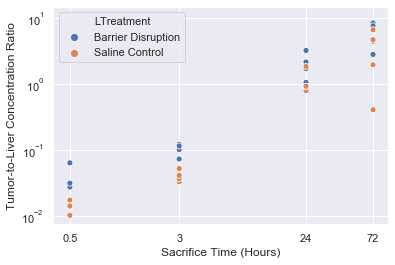

In [15]:
ax = sns.scatterplot(x='Time', y='Concentration', hue='LTreatment', data=df)
ax.set_xscale('log')
xticks = [0.5, 3, 24, 72]
ax.set_xticks(xticks)
ax.set_xticklabels([str(x) for x in xticks])
ax.set_yscale('log')
ax.set_ylim(0.0075, 15)
ax.set_xlabel('Sacrifice Time (Hours)')
ax.set_ylabel('Tumor-to-Liver Concentration Ratio')

[scatterplot](https://seaborn.pydata.org/generated/seaborn.scatterplot.html) shows a deficiency here, as the *Treatment* dots land on top of each other and  there is no straightforward way to apply jitter.  We can use [stripplot](https://seaborn.pydata.org/generated/seaborn.stripplot.html) instead, however.

Text(0, 0.5, 'Tumor-to-Liver Concentration Ratio')

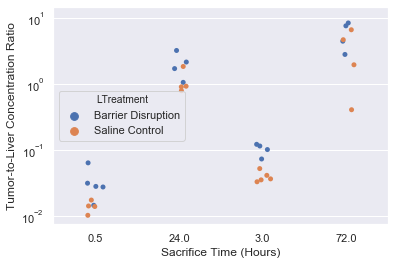

In [16]:
df['STime'] = df['Time'].astype(str)
ax = sns.stripplot(x='STime', y='Concentration', hue='LTreatment', 
                   jitter=True, dodge=False, data=df)
ax.set_yscale('log')
ax.set_ylim(0.0075, 15)
ax.set_xlabel('Sacrifice Time (Hours)')
ax.set_ylabel('Tumor-to-Liver Concentration Ratio')

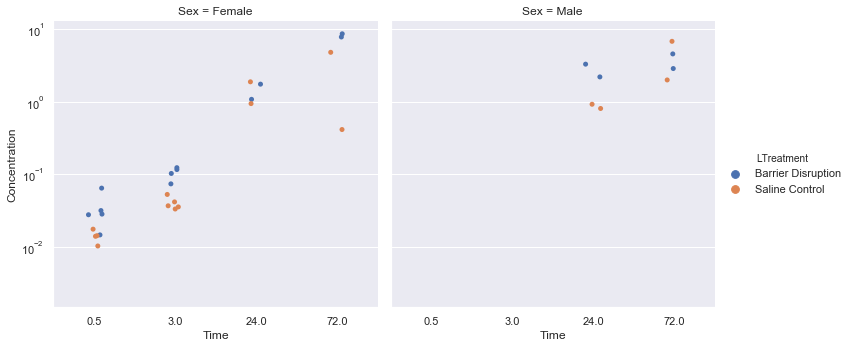

In [17]:
g = sns.catplot(x='Time', y='Concentration', hue='LTreatment', col='Sex',
                   jitter=True, dodge=False, data=df)
g.axes[0][0].set_yscale('log')

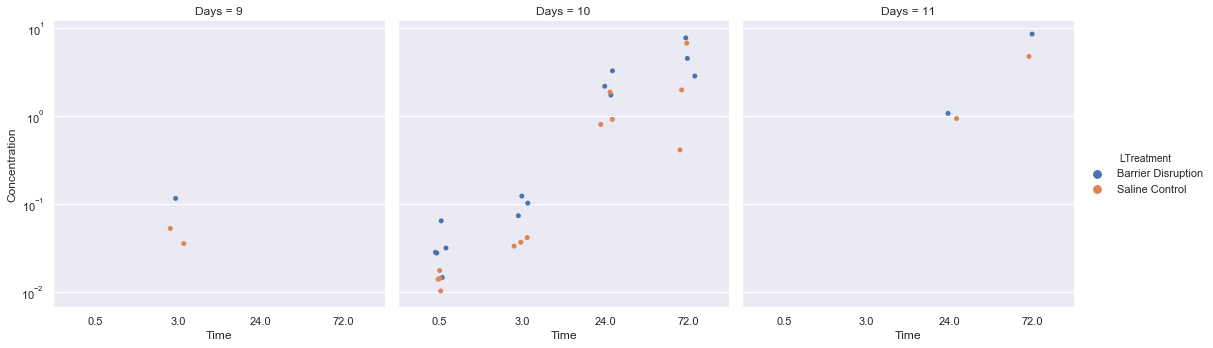

In [18]:
g = sns.catplot(x='Time', y='Concentration', hue='LTreatment', col='Days',
                jitter=True, dodge=False, data=df)
g.axes[0][0].set_yscale('log')

The treatment model chosen is 

$\mu\{antibody | SAC, TREAT, DAYS, FEM, weight, loss, tumor\} = SAC + TREAT + (SAC \times TREAT) + FEM + weight + loss + tumor$

In [21]:
formula = 'np.log(Concentration) ~ C(Time) + Treatment + C(Time):Treatment + Sex + Weight + Loss + Tumor'
model = smf.ols(formula, data=df)
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     np.log(Concentration)   R-squared:                       0.960
Model:                               OLS   Adj. R-squared:                  0.940
Method:                    Least Squares   F-statistic:                     47.87
Date:                   Wed, 25 Sep 2019   Prob (F-statistic):           9.06e-13
Time:                           14:02:21   Log-Likelihood:                -20.606
No. Observations:                     34   AIC:                             65.21
Df Residuals:                         22   BIC:                             83.53
Df Model:                             11                                         
Covariance Type:               nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -3.4379      1.185     -2.901      0.008      -5.896      -0.980
C(Time)[T.3.0]                      1.2020      0.411      2.924      0.008       0.350       2.054
C(Time)[T.24.0]                     3.9355      0.407      9.663      0.000       3.091       4.780
C(Time)[T.72.0]                     5.3671      0.411     13.061      0.000       4.515       6.219
Treatment[T.NS]                    -0.7953      0.370     -2.147      0.043      -1.563      -0.027
Sex[T.Male]                         0.0162      0.346      0.047      0.963      -0.701       0.734
C(Time)[T.3.0]:Treatment[T.NS]     -0.1726      0.537     -0.322      0.751      -1.285       0.940
C(Time)[T.24.0]:Treatment[T.NS]     0.3799      0.570      0.666      0.512      -0.803       1.562
C(Time)[T.72.0]:Treatment[T.NS]    -0.3754      0.556     -0.676      0.506      -1.528       0.777
Weight                             -0.0004      0.005     -0.086      0.932      -0.011       0.010
Loss                               -0.0588      0.029     -2.014      0.056      -0.119       0.002
Tumor                               0.0015      0.001      1.288      0.211      -0.001       0.004
==============================================================================
Omnibus:                        5.395   Durbin-Watson:                   1.723
Prob(Omnibus):                  0.067   Jarque-Bera (JB):                5.487
Skew:                          -0.287   Prob(JB):                       0.0643
Kurtosis:                       4.882   Cond. No.                     4.05e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.05e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Scatterplot of residuals vs fitted values from the fit of logged response on a rich model for explanatory variables

Text(0, 0.5, 'Residuals')

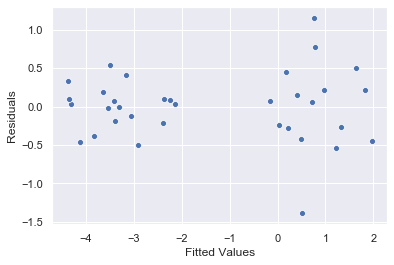

In [11]:
ax = sns.scatterplot(x=results.fittedvalues, y=results.resid)
ax.set_xlabel('Fitted Values')
ax.set_ylabel('Residuals')

In [12]:
df[abs(results.resid) > 1]

,Brain,Liver,Time,Treatment,Days,Sex,Weight,Loss,Tumor,Concentration,LTreatment,STime
30,6250,928,72.000,NS,10,Male,272,11.000,484,6.735,Saline Control,72.0
33,1334,3242,72.000,NS,10,Female,240,6.700,159,0.411,Saline Control,72.0


# Partial Residual Plots

In [ ]:
model_reduced = sm.ols('')

In [22]:
formula = 'np.log(Concentration) ~ C(Time) + Treatment'
rmodel = smf.ols(formula, data=df)
rmodel_fit = rmodel.fit()
rmodel_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     np.log(Concentration)   R-squared:                       0.951
Model:                               OLS   Adj. R-squared:                  0.944
Method:                    Least Squares   F-statistic:                     139.6
Date:                   Wed, 25 Sep 2019   Prob (F-statistic):           1.67e-18
Time:                           14:57:03   Log-Likelihood:                -24.134
No. Observations:                     34   AIC:                             58.27
Df Residuals:                         29   BIC:                             65.90
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -3.5049      0.195    -17.937      0.000      -3.905      -3.105
C(Time)[T.3.0]      1.1341      0.252      4.501      0.000       0.619       1.650
C(Time)[T.24.0]     4.2573      0.259     16.431      0.000       3.727       4.787
C(Time)[T.72.0]     5.1539      0.259     19.892      0.000       4.624       5.684
Treatment[T.NS]    -0.7968      0.183     -4.346      0.000      -1.172      -0.422
==============================================================================
Omnibus:                       12.688   Durbin-Watson:                   1.740
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               17.448
Skew:                          -0.907   Prob(JB):                     0.000163
Kurtosis:                       6.004   Cond. No.                         5.24
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
ddof = (rmodel_fit.df_resid - model_fit.df_resid)
fvalue = ((rmodel_fit.ssr - model_fit.ssr) / ddof) / model_fit.mse_resid
scipy.stats.f.sf(ddof, model_fit.df_resid, fvalue)

0.37488650377406035

This is reasonable evidence that the covariates can be dropped.

In [25]:
np.exp(rmodel_fit.params['Treatment[T.NS]'])

0.45077107764621993

The coefficient of the indicator variable for the blood-brain placebo treatment is -0.7968, so expressed in accordance with the interpretation for log-transformed responses, the median ratio of antibody concentration in the brain tumor to antibody concentration in the liver is estimated to be exp(-0.7968)= 0.4508 times less for the control than for the blood-brain barrier diffusion treatment.  Stated alternatively, the median concentration is expected to be  1/0.4508 = 2.2183 times greater the the diffusion treatment.

# Statistical Conclusion
The median antibody concentration in the tumor (relative to that in the liver) was estimated to be 2.22 times as much for rats receiving the barrier disruption infusion than for those receiving the control infusion (95% confidence interval, from 1.56 to 3.15 times as much).  This multiplicative effect appears to be constant between 1/2 and 72 hours after the infusion (the $p$-value for a test of interaction between treatment and sacrifice time is 0.92 , from an $F$-test on 3 and 26 degrees of freedom.


# Scope of Inference
One hitch in this study is that randomization was not used to assign rats to treatment groups.  This oversight raises the possibility that the estimated relationships might be related to confounding variables over which the experimenter exercised no control.  Including the measured covariates in the model helps alleviate some concern, and the results appear to no have been affected by these potential confounding variables.  Nevertheless, causal implications can only be justified on the tenuous assumption that the assignment method used was as effect-neutral as a random assignment would have been.